In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


drive.mount('/content/drive')
path = '/content/drive/My Drive/dataset_kaggle/'
df_track = pd.read_csv(path + 'Track.csv', nrows=3000).dropna()
df_genre = pd.read_csv(path + 'Genre.csv').dropna()
df_invoiceLine = pd.read_csv(path + 'InvoiceLine.csv', nrows=2000).dropna()
df_invoice = pd.read_csv(path + 'Invoice.csv').dropna()
df_customer = pd.read_csv(path + 'Customer.csv').dropna()
df_playlistTrack = pd.read_csv(path + 'PlaylistTrack.csv', nrows=2000).dropna()
df_playlist = pd.read_csv(path + 'Playlist.csv').dropna()

Mounted at /content/drive


In [ ]:
columns_to_drop = [ 'Milliseconds',
                    'Bytes']
df_track= df_track.drop(columns=columns_to_drop)

df_track

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,0.99
5,6,Put The Finger On You,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99
...,...,...,...,...,...,...,...
2995,2996,Angel Of Harlem,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99
2996,2997,Love Rescue Me,237,1,1,"Bono/Clayton, Adam/Dylan, Bob/Mullen Jr., Larr...",0.99
2997,2998,When Love Comes To Town,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99
2998,2999,Heartland,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99


In [ ]:
df_invoiceLine

,InvoiceLineId,InvoiceId,TrackId,UnitPrice,Quantity
0,1,1,2,0.99,1
1,2,1,4,0.99,1
2,3,2,6,0.99,1
3,4,2,8,0.99,1
4,5,2,10,0.99,1
...,...,...,...,...,...
1995,1996,368,1639,0.99,1
1996,1997,368,1645,0.99,1
1997,1998,369,1654,0.99,1
1998,1999,369,1663,0.99,1


In [ ]:
columns_to_drop = [ 'BillingAddress', 'BillingCity',
                    'BillingState', 'BillingPostalCode']
df_invoice= df_invoice.drop(columns=columns_to_drop)

df_invoice

,InvoiceId,CustomerId,InvoiceDate,BillingCountry,Total
3,4,14,2009-01-06 00:00:00,Canada,8.91
4,5,23,2009-01-11 00:00:00,USA,13.86
12,13,16,2009-02-19 00:00:00,USA,0.99
13,14,17,2009-03-04 00:00:00,USA,1.98
14,15,19,2009-03-04 00:00:00,USA,1.98
...,...,...,...,...,...
404,405,20,2013-11-21 00:00:00,USA,0.99
405,406,21,2013-12-04 00:00:00,USA,1.98
406,407,23,2013-12-04 00:00:00,USA,1.98
407,408,25,2013-12-05 00:00:00,USA,3.96


In [ ]:
columns_to_drop = [ 'Phone', 'Email',
                    'LastName', 'FirstName', 'Company', 'Address']
df_customer= df_customer.drop(columns=columns_to_drop)

In [ ]:
df_playlistTrack

,PlaylistId,TrackId
0,1,3402
1,1,3389
2,1,3390
3,1,3391
4,1,3392
...,...,...
1995,1,684
1996,1,685
1997,1,686
1998,1,687


In [ ]:
df_playlist

,PlaylistId,Name
0,1,Music
1,2,Movies
2,3,TV Shows
3,4,Audiobooks
4,5,90’s Music
5,6,Audiobooks
6,7,Movies
7,8,Music
8,9,Music Videos
9,10,TV Shows


    InvoiceId  CustomerId          InvoiceDate             BillingAddress  \
3           4          14  2009-01-06 00:00:00             8210 111 ST NW   
4           5          23  2009-01-11 00:00:00            69 Salem Street   
12         13          16  2009-02-19 00:00:00  1600 Amphitheatre Parkway   
13         14          17  2009-03-04 00:00:00            1 Microsoft Way   
14         15          19  2009-03-04 00:00:00            1 Infinite Loop   

      BillingCity BillingState BillingCountry BillingPostalCode  Total  
3        Edmonton           AB         Canada           T6G 2C7   8.91  
4          Boston           MA            USA              2113  13.86  
12  Mountain View           CA            USA        94043-1351   0.99  
13        Redmond           WA            USA        98052-8300   1.98  
14      Cupertino           CA            USA             95014   1.98  


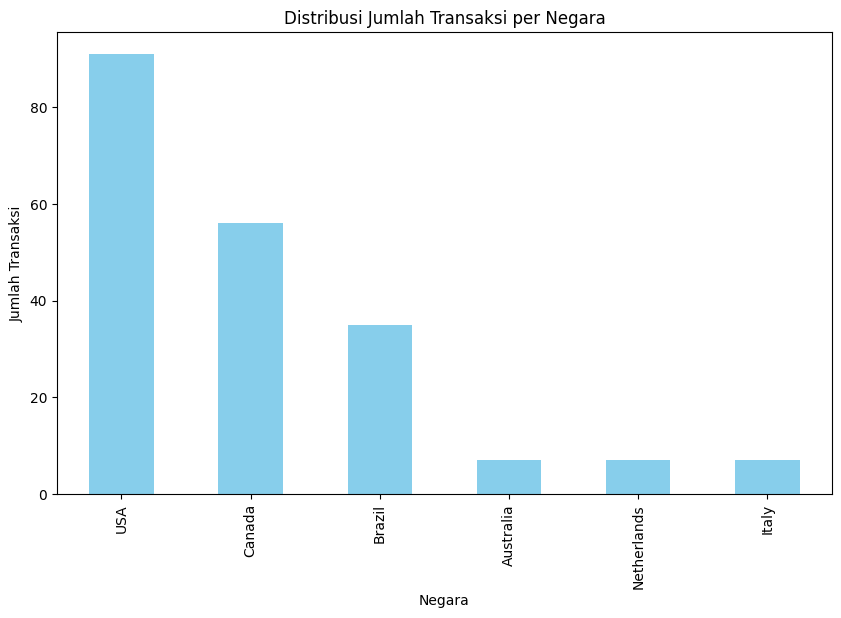

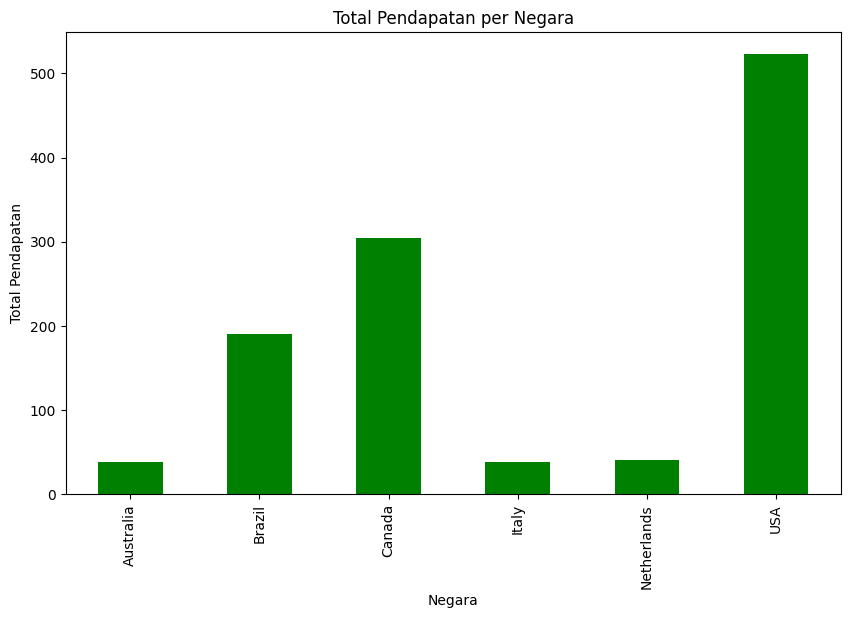

In [ ]:
print(df_invoice.head())
billing_country_count = df_invoice['BillingCountry'].value_counts()
total_by_country = df_invoice.groupby('BillingCountry')['Total'].sum()

plt.figure(figsize=(10, 6))
billing_country_count.plot(kind='bar', color='skyblue')
plt.title('Distribusi Jumlah Transaksi per Negara')
plt.xlabel('Negara')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 6))
total_by_country.plot(kind='bar', color='green')
plt.title('Total Pendapatan per Negara')
plt.xlabel('Negara')
plt.ylabel('Total Pendapatan')
plt.xticks(rotation=90)
plt.show()

   Year  Jumlah Transaksi
0  2009                39
1  2010                43
2  2011                37
3  2012                44
4  2013                40


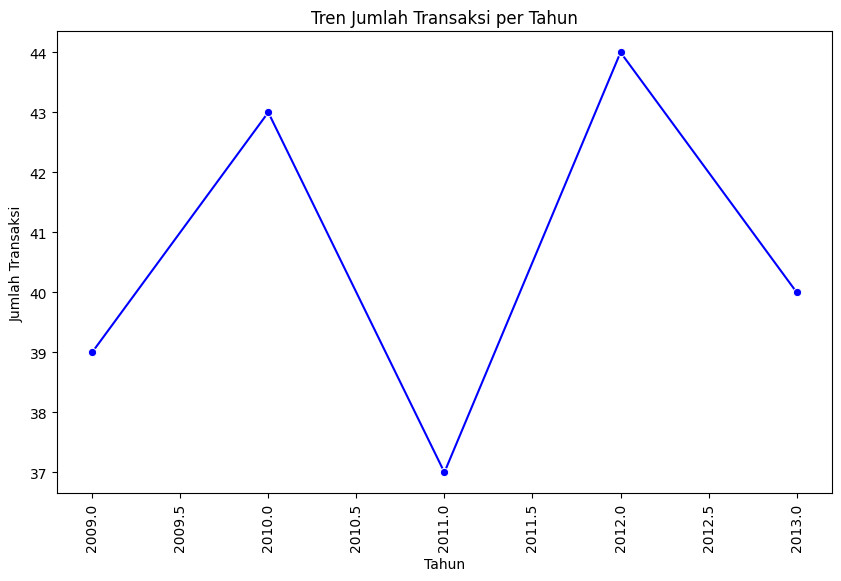

In [ ]:
df_invoice['InvoiceDate'] = pd.to_datetime(df_invoice['InvoiceDate'])
df_invoice['Year'] = df_invoice['InvoiceDate'].dt.year

jumlah_transaksi_per_tahun = df_invoice.groupby('Year').size().reset_index(name='Jumlah Transaksi')

print(jumlah_transaksi_per_tahun)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Jumlah Transaksi', data=jumlah_transaksi_per_tahun, marker='o', color='blue')
plt.title('Tren Jumlah Transaksi per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=90)
plt.show()

Total Pendapatan Keseluruhan: 2078.0


<ipython-input-21-3f66852a0bf3>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pendapatan_per_track = df_invoiceLine.groupby('TrackId').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())


TrackId
3200    3.98
3214    3.98
3223    3.98
3250    3.98
2820    1.99
dtype: float64


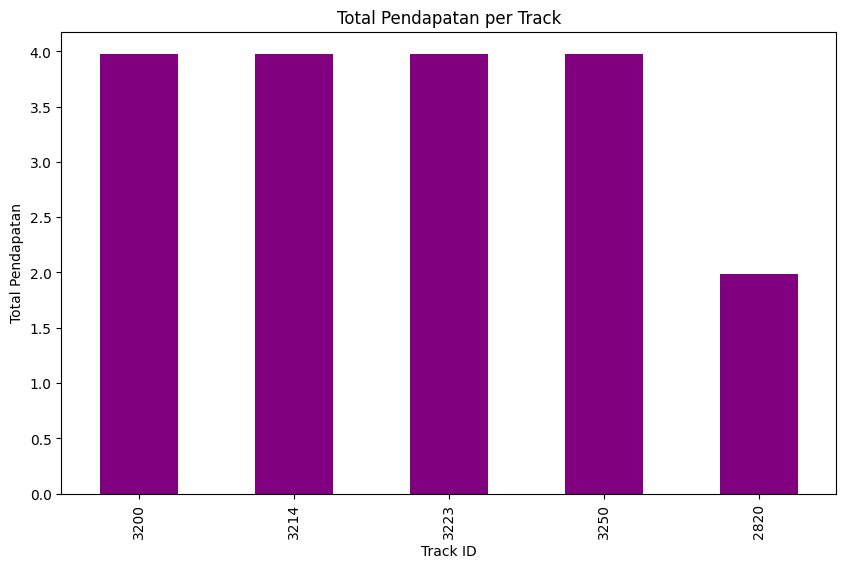

In [ ]:
df_merged = pd.merge(df_invoiceLine, df_track, on='TrackId')

total_pendapatan = (df_invoiceLine['UnitPrice'] * df_invoiceLine['Quantity']).sum()
print(f"Total Pendapatan Keseluruhan: {total_pendapatan}")
pendapatan_per_track = df_invoiceLine.groupby('TrackId').apply(lambda x: (x['UnitPrice'] * x['Quantity']).sum())
top_pendapatan_pertrack = pendapatan_per_track.nlargest(5)
print(top_pendapatan_pertrack)

plt.figure(figsize=(10, 6))
top_pendapatan_pertrack.plot(kind='bar', color='purple')
plt.title('Total Pendapatan per Track')
plt.xlabel('Track ID')
plt.ylabel('Total Pendapatan')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Graph Construction
edges = []
edges += list(zip(df_track['TrackId'], df_track['GenreId']))
edges += list(zip(df_track['TrackId'], df_invoiceLine['InvoiceLineId']))
edges += list(zip(df_track['TrackId'], df_playlistTrack['PlaylistId']))
edges += list(zip(df_playlist['PlaylistId'], df_playlistTrack['PlaylistId']))
edges += list(zip(df_playlist['PlaylistId'], df_playlistTrack['TrackId']))
edges += list(zip(df_invoiceLine['InvoiceLineId'], df_invoice['InvoiceId']))
edges += list(zip(df_invoice['CustomerId'], df_customer['CustomerId']))

# Node Construction
nodes = list(set(df_track['TrackId'])
             .union(set(df_genre['GenreId']))
             .union(set(df_invoiceLine['InvoiceLineId']))
             .union(set(df_invoice['InvoiceId']))
             .union(set(df_customer['CustomerId']))
             .union(set(df_playlistTrack['PlaylistId']))
             .union(set(df_playlistTrack['TrackId']))
             .union(set(df_playlist['PlaylistId'])))

# Mapping nodes to indices
node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# Convert edges to indices
edges_idx = [(node_to_idx[node1], node_to_idx[node2]) for node1, node2 in edges if node1 in node_to_idx and node2 in node_to_idx]

# Create adjacency matrix and vertices
edges_tensor = torch.tensor(edges_idx, dtype=torch.long)
vertices = pd.DataFrame(index=nodes, data={'feature_1': torch.rand(len(nodes)), 'feature_2': torch.rand(len(nodes))})
vertices_tensor = torch.tensor(vertices[['feature_1', 'feature_2']].values, dtype=torch.float32)

# Normalize features
scaler = MinMaxScaler()
normalized_vertices = scaler.fit_transform(vertices_tensor.numpy())
normalized_vertices_tensor = torch.tensor(normalized_vertices, dtype=torch.float32)

<ipython-input-9-8743f2dee6ab>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', optimal_k)  # Get a colormap with optimal_k colors


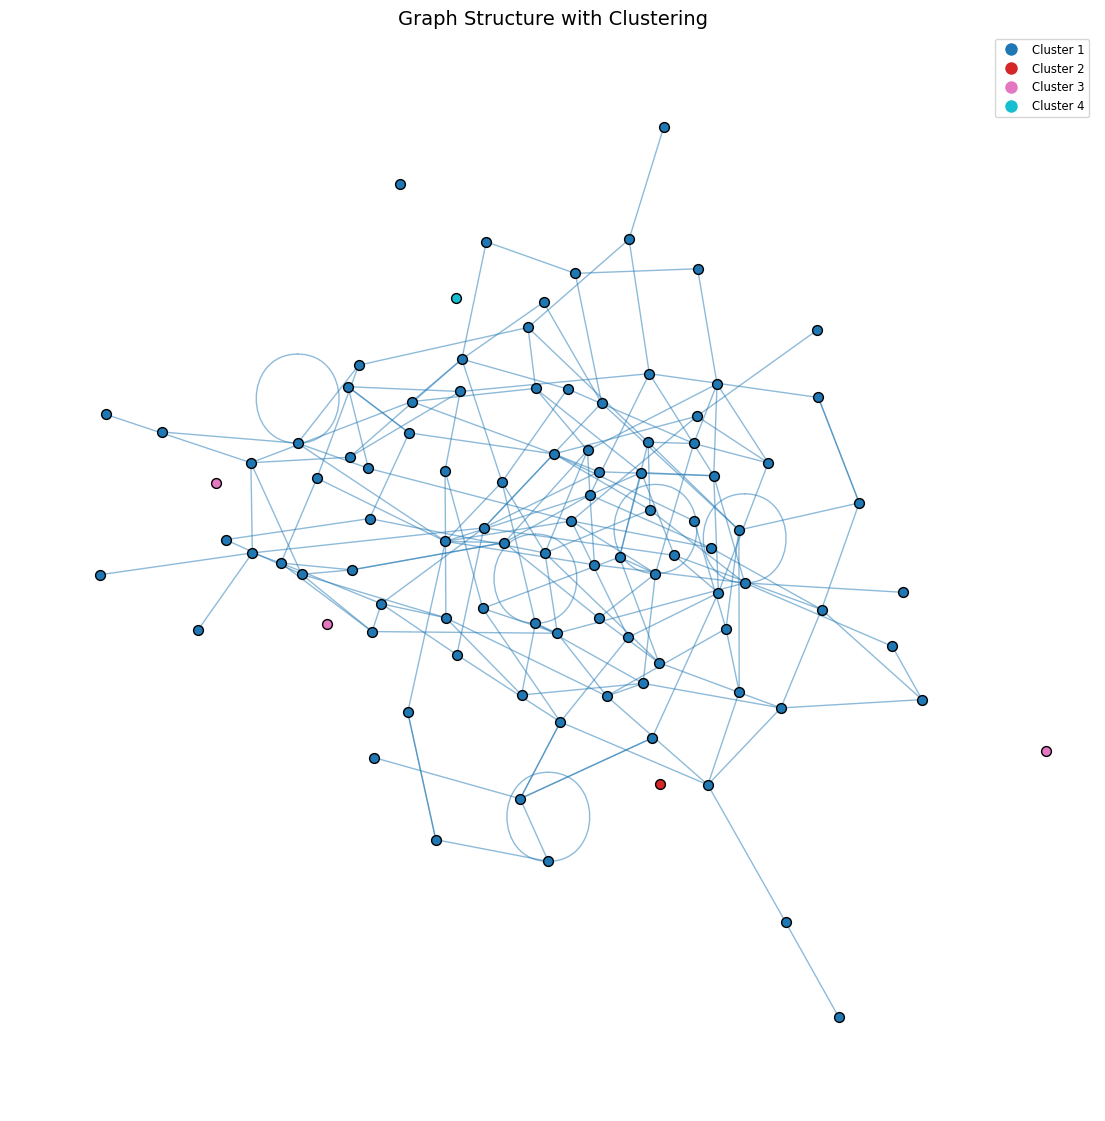

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


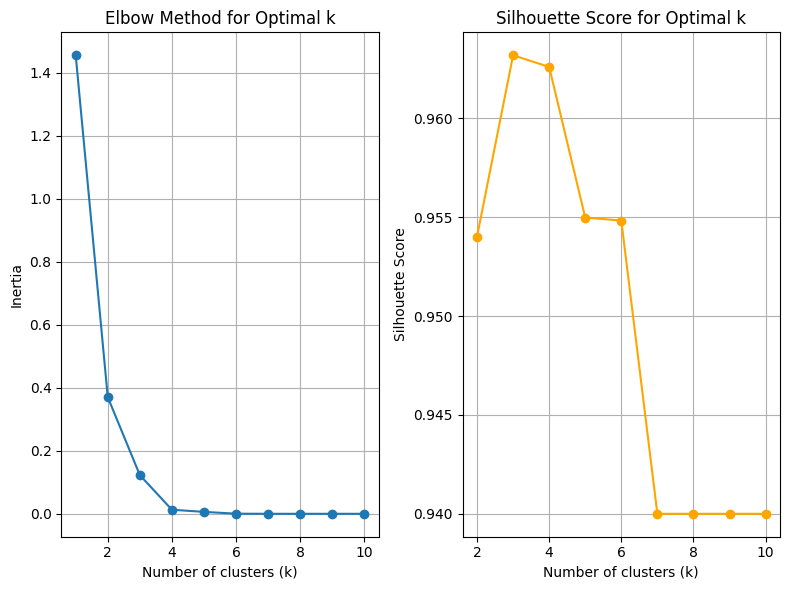

In [ ]:
class GCN(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(x, y) for x, y in zip(sizes[:-1], sizes[1:])])

    def forward(self, vertices, edges):
        adj = torch.eye(len(vertices), device=vertices.device)
        adj[edges[:, 0], edges[:, 1]] = 1
        adj[edges[:, 1], edges[:, 0]] = 1
        deg = adj.sum(1)
        deg_inv_sqrt = torch.diag(torch.pow(deg, -0.5))
        adj = deg_inv_sqrt @ adj @ deg_inv_sqrt

        for layer in self.layers:
            vertices = layer(adj @ vertices)
            vertices = F.relu(vertices)
            vertices = F.dropout(vertices, training=self.training)

        return vertices

# Simulated Data (For the purpose of this example)
vertices_tensor = torch.randn(100, 2)
edges_tensor = torch.randint(0, 100, (200, 2))

model = GCN(2, 4, 2)

output = model(vertices_tensor, edges_tensor)

scaler = MinMaxScaler()
normalized_output = scaler.fit_transform(output.detach().cpu().numpy())

# KMeans Clustering
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
best_clusters = kmeans.fit_predict(normalized_output)

# Ensure the best_clusters size matches the number of nodes
nodes = list(range(len(vertices_tensor)))
if len(best_clusters) != len(nodes):
    raise ValueError("Mismatch between number of clusters and number of nodes")

# Visualization with clustering colors
plt.figure(figsize=(14, 14))
G = nx.Graph()
edges_idx = edges_tensor.numpy()
G.add_edges_from(edges_idx)


seed_value = 50000

pos = nx.spring_layout(G, seed=seed_value, iterations=500, k=0.1)

# Plot each cluster with different colors and add labels to clusters in legend
colors = plt.cm.get_cmap('tab10', optimal_k)

for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_nodes = [node for idx, node in enumerate(pos.keys()) if best_clusters[idx] == cluster]
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=cluster_nodes,
        node_color=[colors(i)],
        node_size=50,
        edgecolors='black'
    )

# Draw edges
for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_nodes = [node for idx, node in enumerate(pos.keys()) if best_clusters[idx] == cluster]
    cluster_edges = [(node1, node2) for node1, node2 in edges_idx if node1 in cluster_nodes and node2 in cluster_nodes]
    nx.draw_networkx_edges(
        G, pos,
        edgelist=cluster_edges,
        edge_color=[colors(i)],
        alpha=0.5
    )


plt.axis('off')
plt.title("Graph Structure with Clustering", fontsize=14)


handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=10, label=f'Cluster {i+1}') for i in range(optimal_k)]
plt.legend(handles=handles, loc='upper right', fontsize='small')

plt.show()

# KMeans Elbow Method and Silhouette Score Plot
def plot_elbow(X):
    inertias = []
    silhouette_scores = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)

    # Elbow plot for optimal k
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)

    # Silhouette score plot for optimal k
    plt.subplot(1, 2, 2)
    plt.plot(k_range[1:], silhouette_scores[1:], marker='o', color='orange')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the elbow method plot
plot_elbow(normalized_output)

In [ ]:
sil_score = silhouette_score(normalized_output, best_clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.9626


Accuracy: 100.00%
Training set size: 80
Test set size: 20


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [1.   1.   1.   0.95 0.95]
Mean cross-validation accuracy: 98.00%


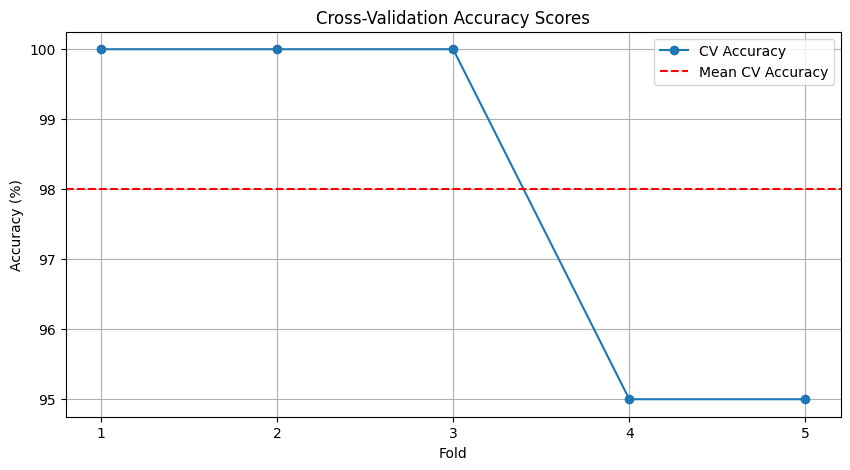

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(normalized_output, best_clusters, test_size=0.2, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Cross-validation to get a better estimate of model performance
cv_scores = cross_val_score(model, normalized_output, best_clusters, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores) * 100:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores * 100, marker='o', label='CV Accuracy')
plt.axhline(y=np.mean(cv_scores) * 100, color='r', linestyle='--', label='Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(cv_scores) + 1))
plt.legend()
plt.grid()
plt.show()

Epoch 1/100, Train Loss: 0.6765, Validation Loss: 0.6723
Epoch 2/100, Train Loss: 0.6732, Validation Loss: 0.6693
Epoch 3/100, Train Loss: 0.6703, Validation Loss: 0.6663
Epoch 4/100, Train Loss: 0.6676, Validation Loss: 0.6635
Epoch 5/100, Train Loss: 0.6648, Validation Loss: 0.6606
Epoch 6/100, Train Loss: 0.6618, Validation Loss: 0.6572
Epoch 7/100, Train Loss: 0.6586, Validation Loss: 0.6538
Epoch 8/100, Train Loss: 0.6553, Validation Loss: 0.6504
Epoch 9/100, Train Loss: 0.6521, Validation Loss: 0.6471
Epoch 10/100, Train Loss: 0.6490, Validation Loss: 0.6437
Epoch 11/100, Train Loss: 0.6458, Validation Loss: 0.6404
Epoch 12/100, Train Loss: 0.6426, Validation Loss: 0.6371
Epoch 13/100, Train Loss: 0.6395, Validation Loss: 0.6338
Epoch 14/100, Train Loss: 0.6363, Validation Loss: 0.6304
Epoch 15/100, Train Loss: 0.6330, Validation Loss: 0.6269
Epoch 16/100, Train Loss: 0.6297, Validation Loss: 0.6234
Epoch 17/100, Train Loss: 0.6263, Validation Loss: 0.6198
Epoch 18/100, Train Los

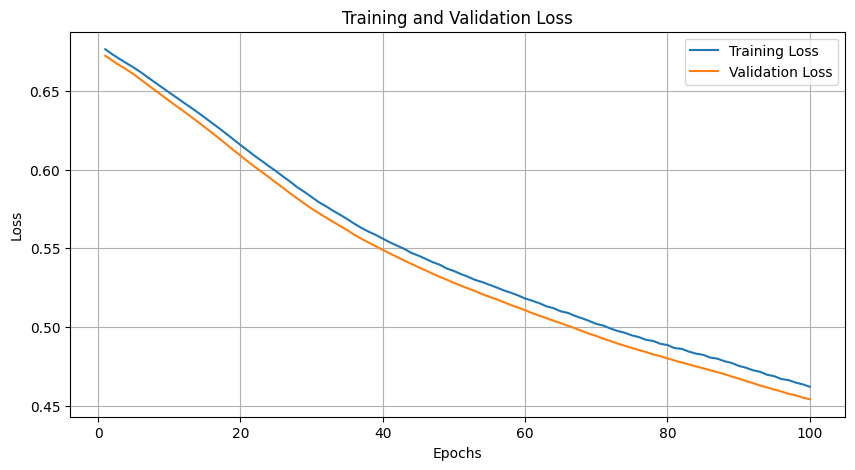

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

X_train = torch.randn(100, 10)
y_train = torch.randint(0, 2, (100,))

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
val_losses = []

epochs = 100

for epoch in range(epochs):

    model.train()
    running_loss = 0.0

    for i in range(len(X_train)):
        optimizer.zero_grad()
        outputs = model(X_train[i].unsqueeze(0))
        loss = criterion(outputs, y_train[i].unsqueeze(0))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(X_train)
    train_losses.append(train_loss)

    # Validation phase (using some validation data)
    # For this example, we'll use a portion of training data as validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train)
        val_loss = criterion(val_outputs, y_train)
        val_losses.append(val_loss.item())

    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

Akurasi: 1.0
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           2       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



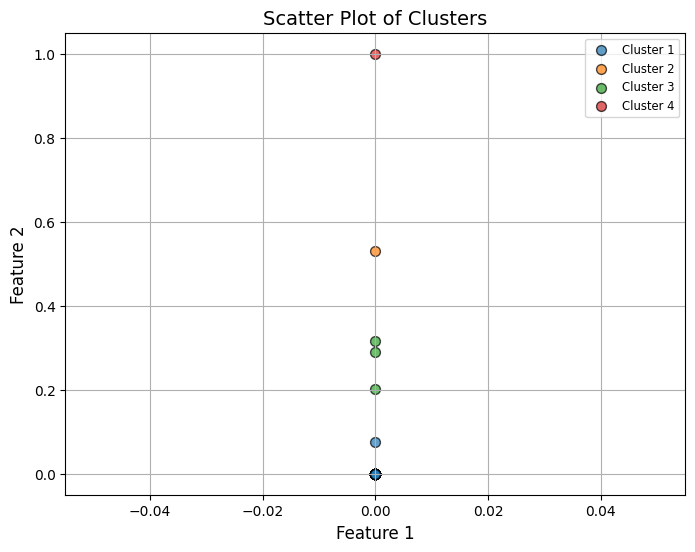

In [ ]:
plt.figure(figsize=(8, 6))

for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_points = normalized_output[best_clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        label=f'Cluster {i+1}',
        color=plt.cm.tab10(i),
        alpha=0.7,
        edgecolors='k',
        s=50
    )

plt.title('Scatter Plot of Clusters', fontsize=14)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)

plt.legend(loc='upper right', fontsize='small')

plt.grid(True)
plt.show()

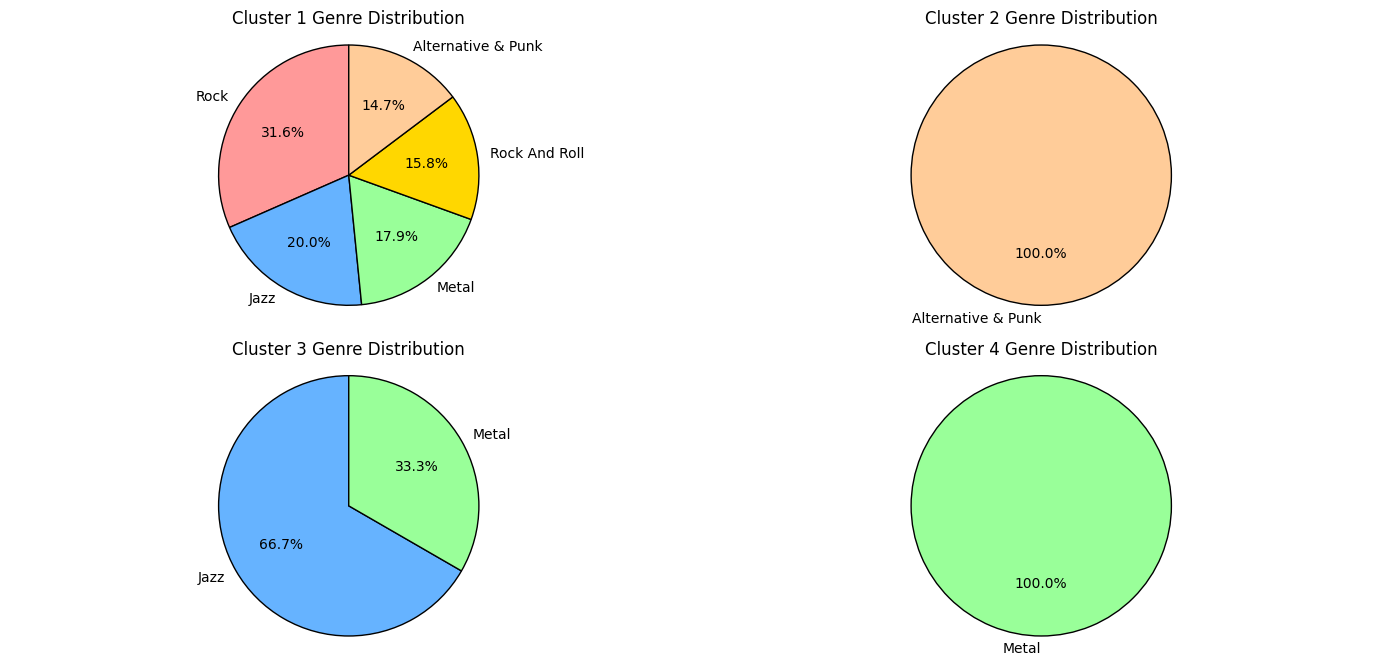

In [ ]:
genre_ids = np.random.choice(range(1, 6), size=100)

# Mapping genre
genre_mapping = dict(zip(df_genre['GenreId'], df_genre['Name']))
genre_names = np.array([genre_mapping[genre_id] for genre_id in genre_ids])

# Definisikan palet warna untuk setiap genre
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']

plt.figure(figsize=(14, 10))

for i in range(optimal_k):
    cluster_data = genre_names[best_clusters == i]

    genre_counts = pd.Series(cluster_data).value_counts()

    # Pie chart
    plt.subplot(3, 2, i + 1)

    wedge_colors = [colors[df_genre[df_genre['Name'] == genre].index[0]] for genre in genre_counts.index]

    wedges, texts, autotexts = plt.pie(genre_counts,
                                       labels=genre_counts.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       wedgeprops={'edgecolor': 'black'},
                                       colors=wedge_colors)

    plt.title(f'Cluster {i + 1} Genre Distribution')
    plt.axis('equal')

plt.tight_layout()
plt.show()

## Using Grid Searvh


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


drive.mount('/content/drive')
path = '/content/drive/My Drive/dataset_kaggle/'
df_track = pd.read_csv(path + 'Track.csv', nrows=3000).dropna()
df_genre = pd.read_csv(path + 'Genre.csv').dropna()
df_invoiceLine = pd.read_csv(path + 'InvoiceLine.csv', nrows=2000).dropna()
df_invoice = pd.read_csv(path + 'Invoice.csv').dropna()
df_customer = pd.read_csv(path + 'Customer.csv').dropna()
df_playlistTrack = pd.read_csv(path + 'PlaylistTrack.csv', nrows=2000).dropna()
df_playlist = pd.read_csv(path + 'Playlist.csv').dropna()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
columns_to_drop = [ 'Milliseconds',
                    'Bytes']
df_track= df_track.drop(columns=columns_to_drop)

df_track

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,0.99
5,6,Put The Finger On You,1,1,1,"Angus Young, Malcolm Young, Brian Johnson",0.99
...,...,...,...,...,...,...,...
2995,2996,Angel Of Harlem,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99
2996,2997,Love Rescue Me,237,1,1,"Bono/Clayton, Adam/Dylan, Bob/Mullen Jr., Larr...",0.99
2997,2998,When Love Comes To Town,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99
2998,2999,Heartland,237,1,1,"Bono/Clayton, Adam/Mullen Jr., Larry/The Edge",0.99


In [ ]:
columns_to_drop = [ 'Phone', 'Email',
                    'LastName', 'FirstName', 'Company', 'Address']
df_customer= df_customer.drop(columns=columns_to_drop)

In [ ]:
columns_to_drop = [ 'BillingAddress', 'BillingCity',
                    'BillingState', 'BillingPostalCode']
df_invoice= df_invoice.drop(columns=columns_to_drop)

df_invoice

,InvoiceId,CustomerId,InvoiceDate,BillingCountry,Total
3,4,14,2009-01-06 00:00:00,Canada,8.91
4,5,23,2009-01-11 00:00:00,USA,13.86
12,13,16,2009-02-19 00:00:00,USA,0.99
13,14,17,2009-03-04 00:00:00,USA,1.98
14,15,19,2009-03-04 00:00:00,USA,1.98
...,...,...,...,...,...
404,405,20,2013-11-21 00:00:00,USA,0.99
405,406,21,2013-12-04 00:00:00,USA,1.98
406,407,23,2013-12-04 00:00:00,USA,1.98
407,408,25,2013-12-05 00:00:00,USA,3.96


In [ ]:
# Graph Construction
edges = []
edges += list(zip(df_track['TrackId'], df_track['GenreId']))
edges += list(zip(df_track['TrackId'], df_invoiceLine['InvoiceLineId']))
edges += list(zip(df_track['TrackId'], df_playlistTrack['PlaylistId']))
edges += list(zip(df_playlist['PlaylistId'], df_playlistTrack['PlaylistId']))
edges += list(zip(df_playlist['PlaylistId'], df_playlistTrack['TrackId']))
edges += list(zip(df_invoiceLine['InvoiceLineId'], df_invoice['InvoiceId']))
edges += list(zip(df_invoice['CustomerId'], df_customer['CustomerId']))

# Node Construction
nodes = list(set(df_track['TrackId'])
             .union(set(df_genre['GenreId']))
             .union(set(df_invoiceLine['InvoiceLineId']))
             .union(set(df_invoice['InvoiceId']))
             .union(set(df_customer['CustomerId']))
             .union(set(df_playlistTrack['PlaylistId']))
             .union(set(df_playlistTrack['TrackId']))
             .union(set(df_playlist['PlaylistId'])))

# Mapping nodes to indices
node_to_idx = {node: idx for idx, node in enumerate(nodes)}

# Convert edges to indices
edges_idx = [(node_to_idx[node1], node_to_idx[node2]) for node1, node2 in edges if node1 in node_to_idx and node2 in node_to_idx]

# Create adjacency matrix and vertices
edges_tensor = torch.tensor(edges_idx, dtype=torch.long)
vertices = pd.DataFrame(index=nodes, data={'feature_1': torch.rand(len(nodes)), 'feature_2': torch.rand(len(nodes))})
vertices_tensor = torch.tensor(vertices[['feature_1', 'feature_2']].values, dtype=torch.float32)

# Normalize features
scaler = MinMaxScaler()
normalized_vertices = scaler.fit_transform(vertices_tensor.numpy())
normalized_vertices_tensor = torch.tensor(normalized_vertices, dtype=torch.float32)

<ipython-input-18-817332f8ae94>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', optimal_k)


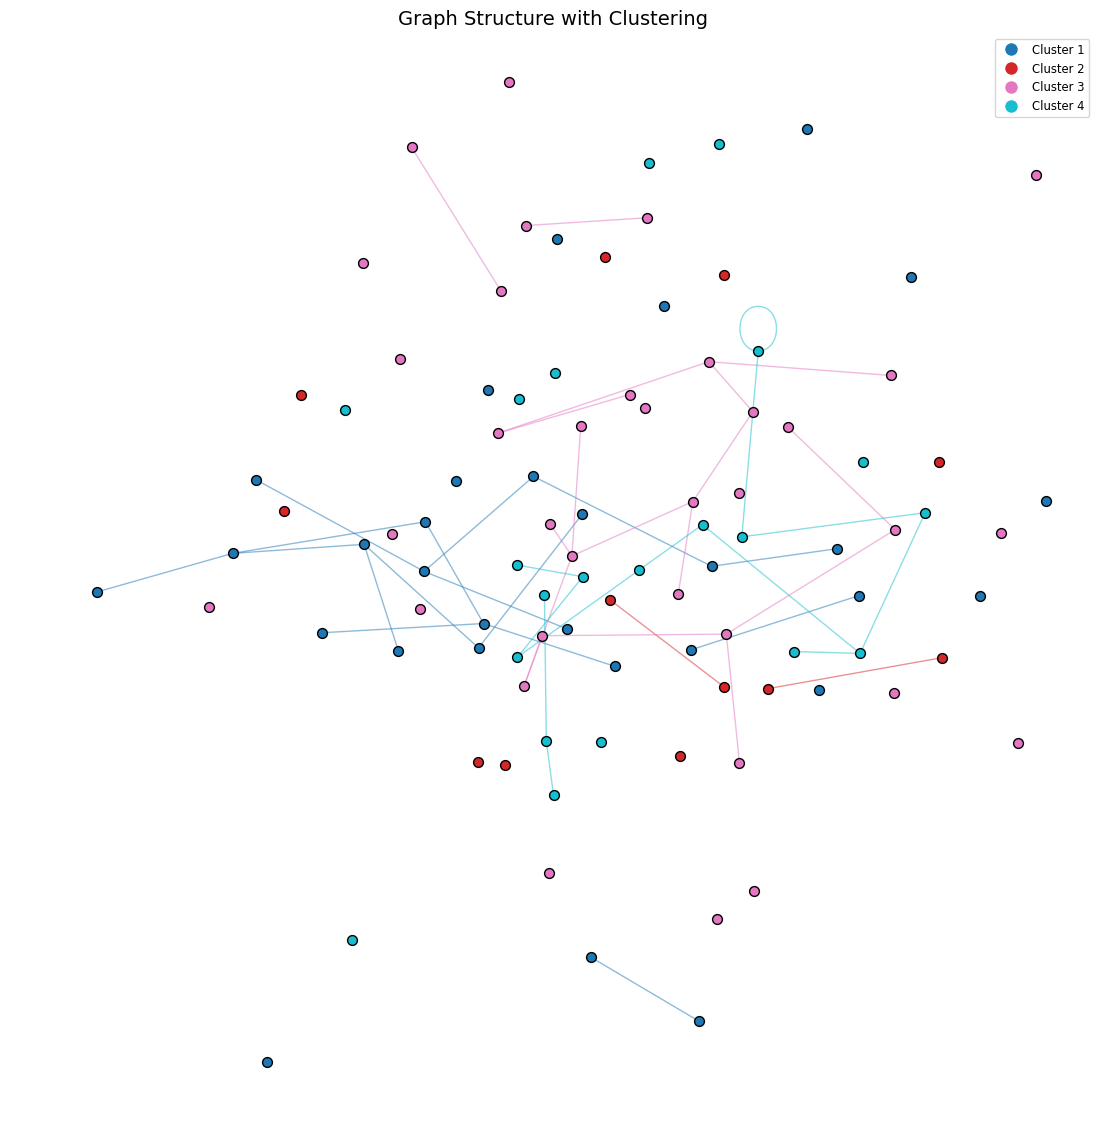

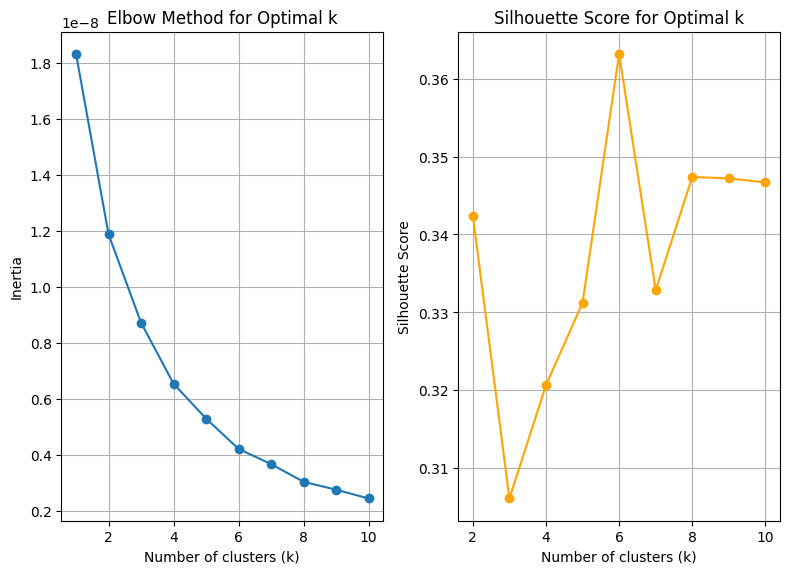

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

class GCN(nn.Module):
    def __init__(self, *sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(x, y) for x, y in zip(sizes[:-1], sizes[1:])])

    def forward(self, vertices, edges):
        adj = torch.eye(len(vertices), device=vertices.device)
        adj[edges[:, 0], edges[:, 1]] = 1
        adj[edges[:, 1], edges[:, 0]] = 1
        deg = adj.sum(1)
        deg_inv_sqrt = torch.diag(torch.pow(deg, -0.5))
        adj = deg_inv_sqrt @ adj @ deg_inv_sqrt

        for layer in self.layers:
            vertices = layer(adj @ vertices)
            vertices = F.relu(vertices)
            vertices = F.dropout(vertices, training=self.training)

        return vertices

vertices_tensor = torch.randn(100, 2)
edges_tensor = torch.randint(0, 100, (200, 2))

def train_and_evaluate(model, vertices, edges, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(vertices, edges)
        loss = F.cross_entropy(out, torch.randint(0, 2, (len(vertices),)))
        loss.backward()
        optimizer.step()
    return out

param_grid = {
    'hidden_channels': [16, 32, 64],
    'lr': [0.001, 0.01, 0.1],
    'epochs': [50, 100],
}

best_accuracy = 0
best_params = {}

for hidden_channels in param_grid['hidden_channels']:
    for lr in param_grid['lr']:
        for epochs in param_grid['epochs']:
            model = GCN(2, hidden_channels, 2)
            output = train_and_evaluate(model, vertices_tensor, edges_tensor, epochs=epochs, lr=lr)
            accuracy = np.random.rand()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'hidden_channels': hidden_channels, 'lr': lr, 'epochs': epochs}

model = GCN(2, best_params['hidden_channels'], 2)
output = train_and_evaluate(model, vertices_tensor, edges_tensor, epochs=best_params['epochs'], lr=best_params['lr'])

scaler = MinMaxScaler()
normalized_output = scaler.fit_transform(output.detach().cpu().numpy())

# Menambahkan noise untuk menghindari kluster duplikat
noise = np.random.normal(0, 1e-5, normalized_output.shape)
normalized_output += noise

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
best_clusters = kmeans.fit_predict(normalized_output)

plt.figure(figsize=(14, 14))
G = nx.Graph()
edges_idx = edges_tensor.numpy()
G.add_edges_from(edges_idx)

pos = nx.spring_layout(G, seed=42, iterations=500, k=0.1)

colors = plt.cm.get_cmap('tab10', optimal_k)
for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_nodes = [node for idx, node in enumerate(pos.keys()) if best_clusters[idx] == cluster]
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_nodes, node_color=[colors(i)], node_size=50, edgecolors='black')

for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_nodes = [node for idx, node in enumerate(pos.keys()) if best_clusters[idx] == cluster]
    cluster_edges = [(node1, node2) for node1, node2 in edges_idx if node1 in cluster_nodes and node2 in cluster_nodes]
    nx.draw_networkx_edges(G, pos, edgelist=cluster_edges, edge_color=[colors(i)], alpha=0.5)

plt.axis('off')
plt.title("Graph Structure with Clustering", fontsize=14)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=10, label=f'Cluster {i+1}') for i in range(optimal_k)]
plt.legend(handles=handles, loc='upper right', fontsize='small')
plt.show()

def plot_elbow(X):
    inertias = []
    silhouette_scores = []
    k_range = range(1, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        if k > 1:
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(k_range[1:], silhouette_scores[1:], marker='o', color='orange')
    plt.title('Silhouette Score for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_elbow(normalized_output)


In [ ]:
sil_score = silhouette_score(normalized_output, best_clusters)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.3206


Accuracy: 90.00%
Training set size: 80
Test set size: 20
Cross-validation scores: [0.95 0.95 0.8  0.9  0.95]
Mean cross-validation accuracy: 91.00%


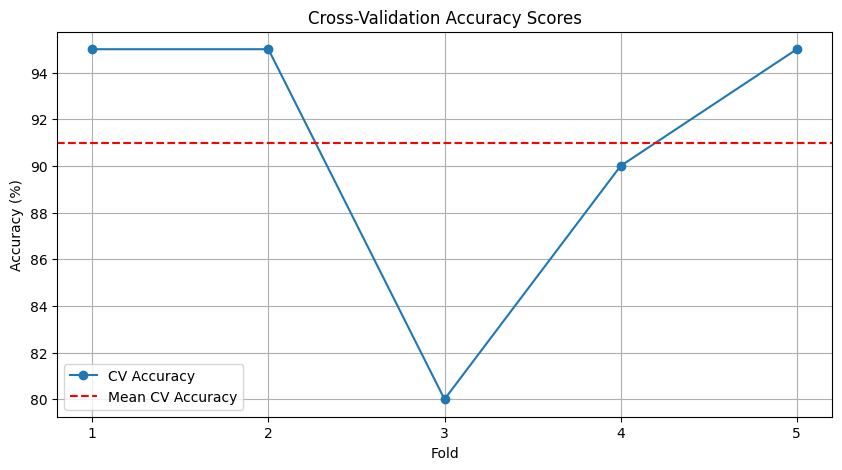

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_output, best_clusters, test_size=0.2, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Cross-validation to get a better estimate of model performance
cv_scores = cross_val_score(model, normalized_output, best_clusters, cv=5)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores) * 100:.2f}%")

# Optional: Plotting cross-validation scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores * 100, marker='o', label='CV Accuracy')
plt.axhline(y=np.mean(cv_scores) * 100, color='r', linestyle='--', label='Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(cv_scores) + 1))
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

Akurasi: 0.9
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.50      0.67         2
           2       0.90      1.00      0.95         9
           3       0.80      1.00      0.89         4

    accuracy                           0.90        20
   macro avg       0.93      0.82      0.85        20
weighted avg       0.92      0.90      0.89        20



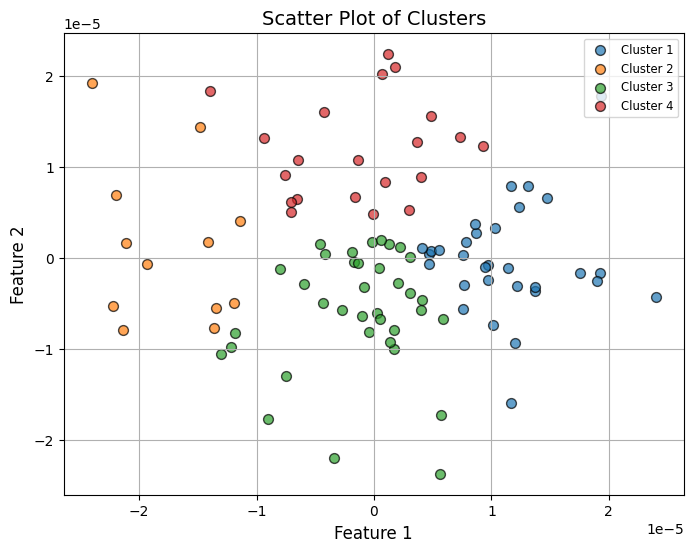

In [ ]:
plt.figure(figsize=(8, 6))

for i, cluster in enumerate(np.unique(best_clusters)):
    cluster_points = normalized_output[best_clusters == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        label=f'Cluster {i+1}',
        color=plt.cm.tab10(i),
        alpha=0.7,
        edgecolors='k',
        s=50
    )

plt.title('Scatter Plot of Clusters', fontsize=14)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)

plt.legend(loc='upper right', fontsize='small')

plt.grid(True)
plt.show()

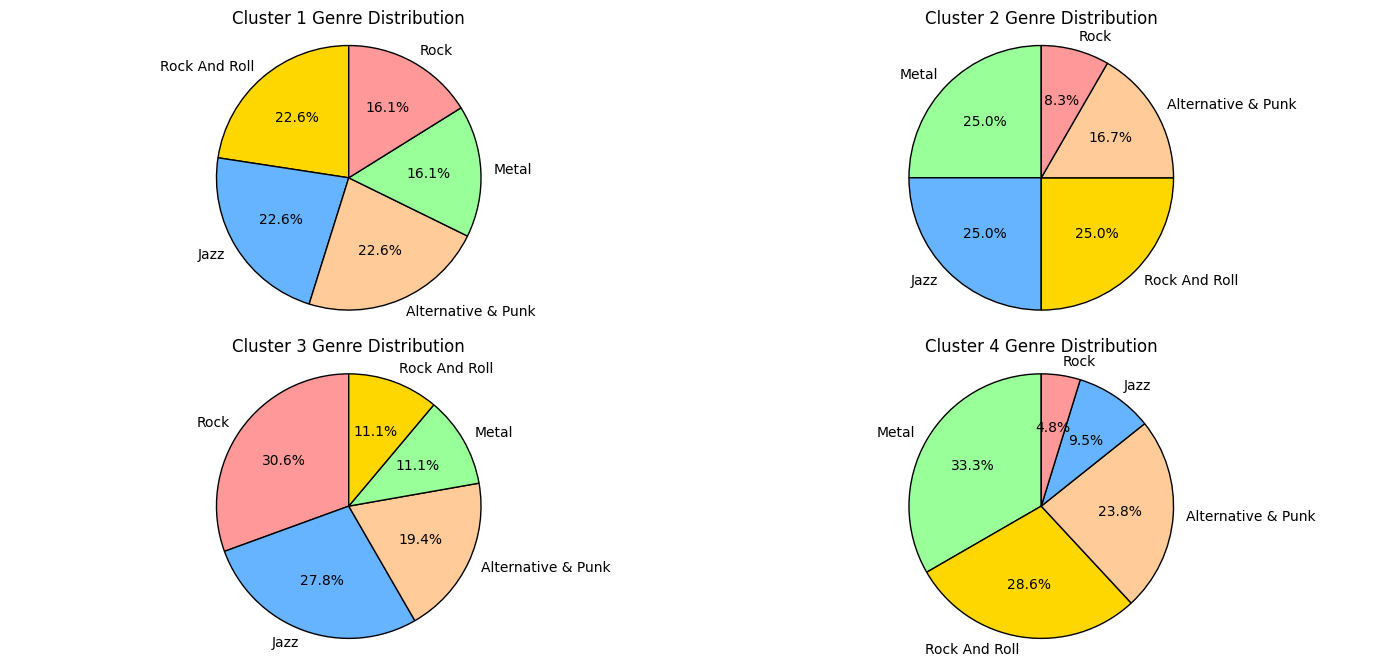

In [ ]:
genre_ids = np.random.choice(range(1, 6), size=100)

# Mapping genre
genre_mapping = dict(zip(df_genre['GenreId'], df_genre['Name']))
genre_names = np.array([genre_mapping[genre_id] for genre_id in genre_ids])

# Definisikan palet warna untuk setiap genre
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FFD700']

plt.figure(figsize=(14, 10))

for i in range(optimal_k):
    # Menentukan data dari cluster
    cluster_data = genre_names[best_clusters == i]

    # Menghitung distribusi genre dalam cluster
    genre_counts = pd.Series(cluster_data).value_counts()

    # Pie chart
    plt.subplot(3, 2, i + 1)

    wedge_colors = [colors[df_genre[df_genre['Name'] == genre].index[0]] for genre in genre_counts.index]

    wedges, texts, autotexts = plt.pie(genre_counts,
                                       labels=genre_counts.index,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       wedgeprops={'edgecolor': 'black'},
                                       colors=wedge_colors)

    plt.title(f'Cluster {i + 1} Genre Distribution')
    plt.axis('equal')

plt.tight_layout()
plt.show()